# Just like `4fold_strat_down_up_no_leakage.ipynb`, but for _uncentred images_
- Split big slide image (.tif) into a grid where each square is [DESIRED_IMAGE_SIZE]x[DESIRED_IMAGE_SIZE] pixels 
    - Produce **4 folds**, based on quadrants of big image
    - TOP LEFT = Q1, TOP RIGHT = Q2, BOTTOM LEFT = Q3, BOTTOM RIGHT = Q4
- Label each based on how many tumour cells they contain. If they contain none, based on if no cells at all or if non tumour cells are present
    - Use cell boundaries information
    - How many tumour cells is defined as ??? IDK MAN. cant be percentage in region, cos in one region 100% might mean 10/10 cells, and in another 100% means 100/100 cells, which would look quite different
- Take a sample within each quadrant of tumour + non tumour cells for multi class classification
    - **Stratified** by category (empty, non tumour only, x amount tumour, y amount tumour, ...)
    - **Downsample** or **upsample** to meet this requirement, if possible
- Output these + visualise these as we go, **copy final images to new folder as train/test data**

### Customisable Parts can be seen through constants below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import sys
import os
import math
import PIL
import random
import geopandas as gpd
from shapely.geometry import Polygon

# constants
BIG_IMAGE_PATH = os.path.join("projectdata", "metadata_code", "GSM7780153_Post-Xenium_HE_Rep1.ome.tif") # path to the big .tif image of all cells
CBR_PATH = os.path.join("projectdata", "metadata_code", "cbr.csv") # cbr = cell boundaries
ANNO_PATH = os.path.join("projectdata", "metadata_code", "41467_2023_43458_MOESM4_ESM.xlsx") # anno = annotation, cell labels
DESIRED_IMAGE_SIZE = 224 # how big do we want our output images to be? 224 for most pretrained cnns, 100 for custom cnns
TOTAL_SAMPLE_SIZE = 1000 # how many images in tumour group + non tumour group (per fold)
EMPTY_CLASS_SIZE = 128 # how many empty/white images to use per fold?  NOTE - 1/2 OF THESE ARE TAKEN FROM FOLDS, 1/2 FROM IMAGE CORNERS
if (math.sqrt(EMPTY_CLASS_SIZE/2)**2 != EMPTY_CLASS_SIZE/2): # make sure its a perfect square
    raise ValueError("Please make sure EMPTY_CLASS_SIZE/2 is a square number, so the final class size makes sense")
RANDOM_SEED = 3888 # for reproducibility
OUTPUT_BASE_TERNARY = os.path.join("projectdata", "images", f"uncentred_ternary_{DESIRED_IMAGE_SIZE}_stratified4fold_{TOTAL_SAMPLE_SIZE}per_seed{RANDOM_SEED}") # path to output images
OUTPUT_BASE_MULTI = os.path.join("projectdata", "images", f"uncentred_multiclass_{DESIRED_IMAGE_SIZE}_stratified4fold_{TOTAL_SAMPLE_SIZE}per_seed{RANDOM_SEED}") # path to output images
GENERATE_TERNARY_DATA = True # actually output data for tumour/non tumour/empty?
GENERATE_MULTI_DATA = True # actually output data for high tumour/low tumour/non tumour/empty or however its defined later on

# setting up the environment
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(sys.version)

3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


## Reading in the big image and saving coords of each grid sqaure

### Read + split into quadrants (only want coords at this point)

In [2]:
# remove the limit for large images 
PIL.Image.MAX_IMAGE_PIXELS = None  

# open image
big_image = PIL.Image.open(BIG_IMAGE_PATH)
width, height = big_image.size
x_mid, y_mid = width // 2, height // 2

big_image.close()
del big_image # free up memory

# define the coordinates for the four quadrants, [(left, top, right, bottom)  for Q1/top left, ... for Q2, top right, ...]
quadrant_coords = [
                    (0, 0, x_mid, y_mid),
                    (width - x_mid, 0, width, y_mid),
                    (0, height - y_mid, x_mid, height),
                    (width - x_mid, height - y_mid, width, height)
                   ]

# # crop the big image
# quadrants = [] #[Q1, Q2, Q3, Q4]
# quadrants.append(big_image.crop(top_left).copy())
# quadrants.append(big_image.crop(top_right).copy())
# quadrants.append(big_image.crop(bottom_left).copy())
# quadrants.append(big_image.crop(bottom_right).copy())

### Visualise quadrants (CUT for now)

In [35]:
# # pretty memory intensive, so commented out for now. have visually checked that these are correct already
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# axes[0, 0].imshow(quadrants[0])
# axes[0, 0].set_title("Top Left")
# axes[0, 1].imshow(quadrants[1])
# axes[0, 1].set_title("Top Right")
# axes[1, 0].imshow(quadrants[2])
# axes[1, 0].set_title("Bottom Left")
# axes[1, 1].imshow(quadrants[3])
# axes[1, 1].set_title("Bottom Right")

# for ax in axes.flatten():
#     ax.axis("off")

# plt.tight_layout()
# plt.show()

### Save coords of grid sqaures within quadrants
- NOTE annotations are ONLY GIVEN FOR CERTAIN REGIONS
- will ignore grids outside this region

In [3]:
# check the boundaires of our cbr data. any grids outside this region might have cells that just werent labelled
cbr = pd.read_csv(CBR_PATH)  # Contains index, axis-0, axis-1
min_x = cbr["axis-1"].min()
min_y = cbr["axis-0"].min()
max_x = cbr["axis-1"].max()
max_y = cbr["axis-0"].max()
print(f"{min_x}, {min_y}, {max_x}, {max_y}")
print((max_x - min_x)/DESIRED_IMAGE_SIZE)
print((max_y - min_y)/DESIRED_IMAGE_SIZE)
print(((max_x - min_x)/DESIRED_IMAGE_SIZE) * ((max_y - min_y)/DESIRED_IMAGE_SIZE))

5936.51168438575, 6719.45407623984, 26877.4601087138, 21784.5683173948
93.48637689432165
67.25497429087035
6287.423874574219


In [4]:
# store coord of each grid sqaure, relative to the entire big image
grids = [[],[],[],[]]
for idx, coords in enumerate(quadrant_coords):
    # reverse order, so we cutoff only the empty outside, not the useful inside
    for i in range(x_mid, 0, -DESIRED_IMAGE_SIZE):
        for j in range(y_mid, 0, -DESIRED_IMAGE_SIZE):
            # define the box for cropping, (left, top, right, bottom)
            box = (i - DESIRED_IMAGE_SIZE, j - DESIRED_IMAGE_SIZE, i, j)
            
            # ignore boxes that are too close to the edges (this will crop to a box of the wrong size)
            if box[0] < DESIRED_IMAGE_SIZE or box[1] < DESIRED_IMAGE_SIZE:
                continue

            #square_coords.append(box)

            # take boundaries of quadrant, and adjust to make grid sqaures
            transformed_coords = (coords[0] + (i - DESIRED_IMAGE_SIZE), # move left boundary in +ve direction, for new left)
                                    coords[1] + (j - DESIRED_IMAGE_SIZE), # move top boundary in +ve direction, for new top
                                    coords[0] + (i), # move left boundary in +ve direction + image size, for new right
                                    coords[1] + (j)) # move top boundary in +ve direction + image size, for new bottom
            

            # ignore grids outside annotated area
            if transformed_coords[0] < min_x or transformed_coords[1] < min_y or transformed_coords[2] > max_x or transformed_coords[3] > max_y:
                continue 

            grids[idx].append(transformed_coords)

print(len(grids[0]))
print(len(grids[1]))
print(len(grids[2]))
print(len(grids[3]))
coord_df = pd.DataFrame({"quadrant": ["Q1" for i in range(len(grids[0]))] + ["Q2" for i in range(len(grids[1]))] + ["Q3" for i in range(len(grids[2]))] + ["Q4" for i in range(len(grids[3]))],
                         "box": grids[0] + grids[1] + grids[2] + grids[3]})

print(coord_df.sample(5, random_state=RANDOM_SEED).head())
print(len(coord_df) * 4) # how many overall
print((x_mid // DESIRED_IMAGE_SIZE) * (y_mid // DESIRED_IMAGE_SIZE)) # expected number of grid squares per quadrant NOT CONSIDERING CBR PARTIAL DATA


1008
1176
1764
2058
     quadrant                           box
2246       Q3  (14945, 17073, 15169, 17297)
986        Q1    (5985, 11448, 6209, 11672)
689        Q1      (8897, 8088, 9121, 8312)
2356       Q3  (14273, 20657, 14497, 20881)
3578       Q3    (7777, 19761, 8001, 19985)
24024
3672


### Validate that no grid sqaures overlap, and all are the right size

In [68]:
# THIS TAKES A LONG TIME TO RUN, SO ONLY RUN IT ONCE WHEN YOU CHANGE THE CODE ABOVE
# # Function to check if two boxes overlap
# def boxes_overlap(box1, box2):
#     return not (box1[2] <= box2[0] or box1[0] >= box2[2] or box1[3] <= box2[1] or box1[1] >= box2[3])

# # Check for overlaps and size consistency
# overlap_found = False
# invalid_box = False
# for i, box1 in enumerate(coord_df["box"]):
#     # Check size
#     width = box1[2] - box1[0]
#     height = box1[3] - box1[1]
#     if width != DESIRED_IMAGE_SIZE or height != DESIRED_IMAGE_SIZE:
#         print(f"Error: Box {box1} is not {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE}.")
#         invalid_box = True
    
#     # Check for overlaps
#     for j, box2 in enumerate(coord_df["box"]):
#         if i != j and boxes_overlap(box1, box2):
#             print(f"Error: Box {box1} overlaps with Box {box2}.")
#             overlap_found = True

# if not overlap_found:
#     print("No overlaps found, and all boxes are of the correct size.")

# if not invalid_box:
#     print("No invalid box coords were found")

## Assigning labels to each box/grid square
- We now have a df of coordinates in (left, top, right, bottom) format, that define (in coord space of big image), each grid square
- This can be spatially joined with polygons defined by cell boundaries data, to identify which cells are in which images

### Prepare cell boundary data + generate polygons for coord_df

In [5]:
# various useful maps
cell_group_map = {
    # Immune
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "IRF7+_DCs": "Immune",
    "LAMP3+_DCs": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "Mast_Cells": "Immune",

    #hybrids
    "Stromal_and_T_Cell_Hybrid": "Hybrid",
    "T_Cell_and_Tumor_Hybrid": "Hybrid",
    # in metadata spreadsheets, hybrid has & not 'and's, so need these keys to account for that
    "Stromal_&_T_Cell_Hybrid": "Hybrid",
    "T_Cell_&_Tumor_Hybrid": "Hybrid",

    # Tumor
    "Prolif_Invasive_Tumor": "Tumor",
    "Invasive_Tumor": "Tumor",

    #early stage cancer 
    "DCIS_1": "Early stage cancer",
    "DCIS_2": "Early stage cancer",
    # same as for hybrids, just underscores vs spaces 
    "DCIS 1": "Early stage cancer",
    "DCIS 2": "Early stage cancer",
    

    # Connective tissue
    "Stromal": "Connective tissue",
    "Perivascular-Like": "Connective tissue",
    "Myoepi_ACTA2+": "Connective tissue",
    "Myoepi_KRT15+": "Connective tissue",

    #endothelial
    "Endothelial": "Endothelial",

    # Unlabeled
    "Unlabeled": "Unlabeled"
}

# manually calculated from above. number of keys in map cant be counted, as multiple punctuation versions exist
group_sizes = {"Immune": 8, "Hybrid": 2, "Tumor": 2, "Early stage cancer": 2, "Connective tissue": 4, "Endothelial":1, "Unlabeled":1}

# NOTE - HYRBID + UNLABELLED SHOULD NOT BE CONSIDERED HERE. the # of keys per group is used
group_to_binary_map = {"Immune": "Non-Tumor", "Tumor": "Tumor", "Early stage cancer": "Tumor", "Connective tissue": "Non-Tumor", "Endothelial":"Non-Tumor"}

In [13]:
# preparing coord_df
coord_df["grid_id"] = [str(math.floor(box[0]/DESIRED_IMAGE_SIZE)) + "_" + str(math.floor(box[1]/DESIRED_IMAGE_SIZE)) for box in coord_df["box"]]

# function to convert a bounding box in PIL format to a polygon
def box_to_polygon(box):
    left, top, right, bottom = box
    return Polygon([(left, top), (left, bottom), (right, bottom), (right, top)])
coord_df["geometry"] = coord_df["box"].apply(box_to_polygon)

# get this into long format
print(coord_df.head(2))

  quadrant                           box grid_id  \
0       Q1  (15169, 11896, 15393, 12120)   67_53   
1       Q1  (15169, 11672, 15393, 11896)   67_52   

                                            geometry  
0  POLYGON ((15169 11896, 15169 12120, 15393 1212...  
1  POLYGON ((15169 11672, 15169 11896, 15393 1189...  


In [7]:
# preparing cell_df
# load coordinate files
cbr = pd.read_csv(CBR_PATH)  # Contains index, axis-0, axis-1
anno = pd.read_excel(ANNO_PATH, sheet_name=1)  # Contains cell_id and Cluster

anno["index"] = anno.index + 1  # Ensure cell_id matches index
print(anno.head(2))
print(cbr.head(2))

# Group by "index" and create polygons based on points defining each index
cbr = cbr.groupby("index", as_index=False).apply(
    lambda group: Polygon(zip(group["axis-1"], group["axis-0"]))
).rename(columns={None: "geometry"})
print(cbr.head(2))

# merge the dfs based on index, to get cluster info for each cell polygon
cell_df = pd.merge(cbr, anno[["index", "Cluster"]], on="index")
cell_df["group"] = cell_df["Cluster"].map(cell_group_map).map(group_to_binary_map)
# at this stage ANY UNLABELLED/HYBRID GO TO NA
# cell_df = cell_df[cell_df["group"].notna()] # THIS MAKES THEM ALL BECOME 'EMPTY' down the track which breaks it all
cell_df.loc[cell_df["group"].isna(), "group"] = "Invalid"
print(cell_df["group"].unique())
print(cell_df.head(2)) # NOTE - axis-0/1 correspond to big .tif image coords, dunno what centroid values corresond to (maybe scaled, like microns or smth)

   Barcode  UMAP_DIM1  UMAP_DIM2 Cluster  transcript_counts  x_centroid  \
0        1        NaN        NaN  DCIS 2                 28  847.259912   
1        2        NaN        NaN  DCIS 2                 94  826.341995   

   y_centroid  gene_counts  index  
0  326.191365           15      1  
1  328.031830           38      2  
   index        axis-0       axis-1
0      1  20795.624215  8295.401252
1      1  20793.214569  8280.106238
   index                                           geometry
0      1  POLYGON ((8295.40125176241 20795.6242151217, 8...
1      2  POLYGON ((8204.704296363 20798.562785364, 8201...
['Tumor' 'Invalid' 'Non-Tumor']
   index                                           geometry Cluster  group
0      1  POLYGON ((8295.40125176241 20795.6242151217, 8...  DCIS 2  Tumor
1      2  POLYGON ((8204.704296363 20798.562785364, 8201...  DCIS 2  Tumor


C:\Users\30300\AppData\Local\Temp\ipykernel_19064\1523214323.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cbr = cbr.groupby("index", as_index=False).apply(


### Spatially join all cells to grids containing them
- grid_gdf now acts as metadata for the grid_ids

In [14]:
# Make GeoDataFrames
grid_gdf = gpd.GeoDataFrame(coord_df, geometry="geometry")#, crs="EPSG:4326")
print(len(grid_gdf))
cell_gdf = gpd.GeoDataFrame(cell_df, geometry="geometry")#, crs="EPSG:4326")

# keep all cells that are within (contained by) each grid polygon
joined_cell_grid_gdf = gpd.sjoin(cell_gdf, grid_gdf, how="right", predicate="within").drop(columns=["index_left0", "box", "quadrant", "index", "geometry"])
print(joined_cell_grid_gdf.head())
print(len(joined_cell_grid_gdf["grid_id"].unique())) # IF THIS IS NOT THE SAME AS LEN GRID, JOIN OPERATION WAS INCORRECT
print(joined_cell_grid_gdf[joined_cell_grid_gdf["Cluster"].isna()].head())
# Optional: rename columns or drop spatial index info
#joined_gdf = joined_gdf.rename(columns={"index_left": "cell_index", "index_right": "grid_index"})

#print(joined_gdf.head())

6006
   Cluster      group grid_id
0  Stromal  Non-Tumor   67_53
0  Stromal  Non-Tumor   67_53
0  Stromal  Non-Tumor   67_53
0  Stromal  Non-Tumor   67_53
0  Stromal  Non-Tumor   67_53
6006
   Cluster group grid_id
10     NaN   NaN   67_43
16     NaN   NaN   67_37
19     NaN   NaN   67_34
43     NaN   NaN   66_34
44     NaN   NaN   66_33


### Aggregating over grid_id in various ways
- **THIS IS CRITICAL FOR DEFINING CLASSIFICATION PROBLEM DOWN THE LINE**
- ternary group 

In [15]:

annotated_grid_df_cluster = joined_cell_grid_gdf.drop(columns="group").groupby(by=["grid_id", "Cluster"]).size().unstack(fill_value=0).reset_index()
annotated_grid_df_group = joined_cell_grid_gdf.drop(columns="Cluster").groupby(by=["grid_id", "group"]).size().unstack(fill_value=0).reset_index()

print(annotated_grid_df_cluster.head(1))
print(annotated_grid_df_group.head(1))
print(len(annotated_grid_df_group))

Cluster grid_id  B_Cells  CD4+_T_Cells  CD8+_T_Cells  DCIS 1  DCIS 2  \
0        100_30        0             0             0       0       0   

Cluster  Endothelial  IRF7+_DCs  Invasive_Tumor  LAMP3+_DCs  ...  \
0                  0          0               0           0  ...   

Cluster  Macrophages_2  Mast_Cells  Myoepi_ACTA2+  Myoepi_KRT15+  \
0                    0           0              0              0   

Cluster  Perivascular-Like  Prolif_Invasive_Tumor  Stromal  \
0                        0                      0        3   

Cluster  Stromal_&_T_Cell_Hybrid  T_Cell_&_Tumor_Hybrid  Unlabeled  
0                              0                      0          0  

[1 rows x 21 columns]
group grid_id  Invalid  Non-Tumor  Tumor
0      100_30        0          3      0
5504


66.0
2415
5136
2042


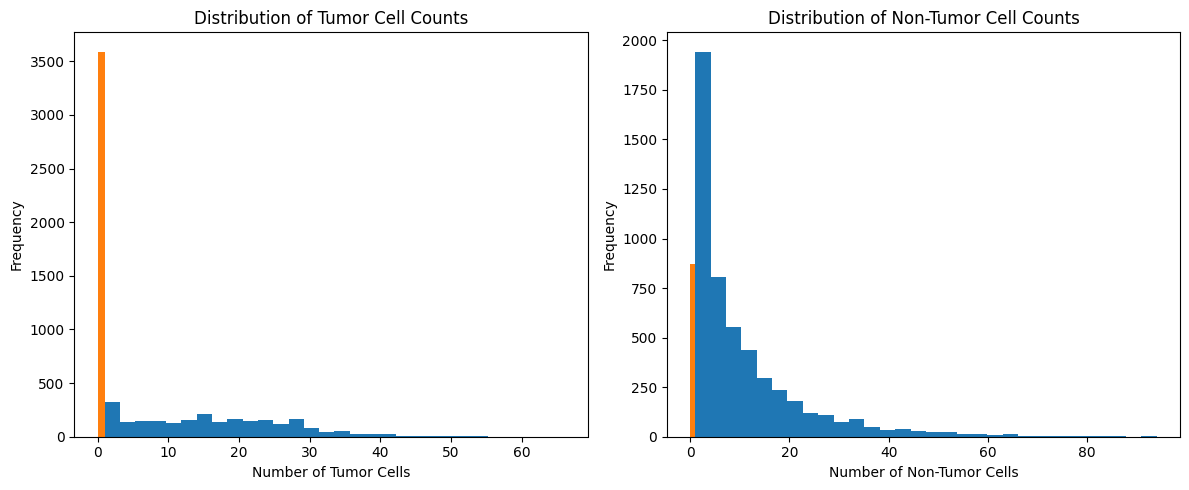

66.0
94.0

Q1 Statistics:
Tumor - Q1: 6.00, Q2: 12.00, Q3: 20.00
Non-Tumor - Q1: 2.00, Q2: 5.00, Q3: 12.00

Q2 Statistics:
Tumor - Q1: 5.00, Q2: 13.00, Q3: 24.00
Non-Tumor - Q1: 2.00, Q2: 7.00, Q3: 16.00

Q3 Statistics:
Tumor - Q1: 10.00, Q2: 18.00, Q3: 25.00
Non-Tumor - Q1: 4.00, Q2: 8.00, Q3: 16.00

Q4 Statistics:
Tumor - Q1: 5.00, Q2: 13.00, Q3: 23.00
Non-Tumor - Q1: 3.00, Q2: 6.00, Q3: 14.00


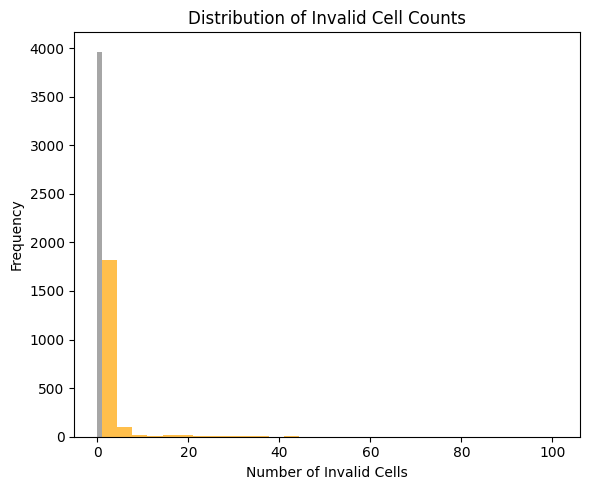

In [16]:
annotated_grid_df = pd.merge(coord_df, annotated_grid_df_group, on='grid_id', how='left')
annotated_grid_df["Non-Tumor"] = annotated_grid_df["Non-Tumor"].fillna(0)
annotated_grid_df["Tumor"] = annotated_grid_df["Tumor"].fillna(0)
annotated_grid_df["Invalid"] = annotated_grid_df["Invalid"].fillna(0)

print(annotated_grid_df["Tumor"].max())
print(len(annotated_grid_df[annotated_grid_df["Tumor"] > 0]))
print(len(annotated_grid_df[annotated_grid_df["Non-Tumor"] > 0]))
print(len(annotated_grid_df[annotated_grid_df["Invalid"] > 0]))

# Create histograms with explicit bins starting at 0 and 1
plt.figure(figsize=(12, 5))

# Tumor cells histogram with explicit bins
plt.subplot(121)
plt.hist(annotated_grid_df["Tumor"][annotated_grid_df["Tumor"] > 0], bins=30)
plt.hist(annotated_grid_df["Tumor"][annotated_grid_df["Tumor"] == 0], bins=[0, 1])
plt.title("Distribution of Tumor Cell Counts")
plt.xlabel("Number of Tumor Cells")
plt.ylabel("Frequency")

# Non-Tumor cells histogram with explicit bins 
plt.subplot(122)
plt.hist(annotated_grid_df["Non-Tumor"][annotated_grid_df["Non-Tumor"] > 0], bins=30)
plt.hist(annotated_grid_df["Non-Tumor"][annotated_grid_df["Non-Tumor"] == 0], bins=[0, 1])
plt.title("Distribution of Non-Tumor Cell Counts") 
plt.xlabel("Number of Non-Tumor Cells")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Calculate quartile values for Tumor cells in each quadrant EXCLUDING 0
tumor_quartiles = {}
nontumor_quartiles = {}
for quadrant in ['Q1', 'Q2', 'Q3', 'Q4']:
    # Only include data where Tumor count > 0 for tumor statistics, and Non-Tumor count > 0 for non-tumor statistics
    tumor_quartiles[quadrant] = annotated_grid_df[(annotated_grid_df['quadrant'] == quadrant) & 
                                                (annotated_grid_df['Tumor'] > 0)]['Tumor'].describe()
    nontumor_quartiles[quadrant] = annotated_grid_df[(annotated_grid_df['quadrant'] == quadrant) & 
                                                    (annotated_grid_df['Non-Tumor'] > 0)]['Non-Tumor'].describe()

print(annotated_grid_df['Tumor'].max())
print(annotated_grid_df['Non-Tumor'].max())

# Print quartile statistics
for quadrant in ['Q1', 'Q2', 'Q3', 'Q4']:
    print(f"\n{quadrant} Statistics:")
    print(f"Tumor - Q1: {tumor_quartiles[quadrant]['25%']:.2f}, Q2: {tumor_quartiles[quadrant]['50%']:.2f}, Q3: {tumor_quartiles[quadrant]['75%']:.2f}")
    print(f"Non-Tumor - Q1: {nontumor_quartiles[quadrant]['25%']:.2f}, Q2: {nontumor_quartiles[quadrant]['50%']:.2f}, Q3: {nontumor_quartiles[quadrant]['75%']:.2f}")

# Invalid cells histogram with explicit bins
plt.figure(figsize=(6, 5))
plt.hist(annotated_grid_df["Invalid"][annotated_grid_df["Invalid"] > 0], bins=30, color='orange', alpha=0.7)
plt.hist(annotated_grid_df["Invalid"][annotated_grid_df["Invalid"] == 0], bins=[0, 1], color='gray', alpha=0.7)
plt.title("Distribution of Invalid Cell Counts")
plt.xlabel("Number of Invalid Cells")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [17]:
annotated_grid_df["ternary_group"] = np.select(
        [
            (annotated_grid_df['Tumor'] > 0),
            (annotated_grid_df['Non-Tumor'] > 0),
            (annotated_grid_df['Invalid'] > 0) # grid is not empty, it has invalid cells present
        ],
        ['Tumor', 'Non-Tumor', 'Invalid'],
        default='Empty'
    )

# cutoffs were chosen by inspection of quartiles + plots above
if DESIRED_IMAGE_SIZE == 224:
    cutoff = 10
elif DESIRED_IMAGE_SIZE == 100:
    cutoff = 2
else:
    raise ValueError("No appropriate value for multiclass classification has been defined yet. need to choose one that splits tumour into > some number and <= some number, with sensible class sizes.")


annotated_grid_df["multi_group"] = np.select(
            [
                (annotated_grid_df['Tumor'] > cutoff),
                (annotated_grid_df['Tumor'] > 0),
                (annotated_grid_df['Non-Tumor'] > 0),
                (annotated_grid_df['Invalid'] > 0) # grid is not empty, it has invalid cells present
            ],
            [f'Over-{cutoff}-Tumor', f'Leq-{cutoff}-Tumor', 'Non-Tumor', 'Invalid'],
            default='Empty'
        )
print(annotated_grid_df.head(5))

  quadrant                           box grid_id  \
0       Q1  (15169, 11896, 15393, 12120)   67_53   
1       Q1  (15169, 11672, 15393, 11896)   67_52   
2       Q1  (15169, 11448, 15393, 11672)   67_51   
3       Q1  (15169, 11224, 15393, 11448)   67_50   
4       Q1  (15169, 11000, 15393, 11224)   67_49   

                                            geometry  Invalid  Non-Tumor  \
0  POLYGON ((15169 11896, 15169 12120, 15393 1212...      0.0        9.0   
1  POLYGON ((15169 11672, 15169 11896, 15393 1189...      0.0        7.0   
2  POLYGON ((15169 11448, 15169 11672, 15393 1167...      1.0       11.0   
3  POLYGON ((15169 11224, 15169 11448, 15393 1144...      0.0        9.0   
4  POLYGON ((15169 11000, 15169 11224, 15393 1122...      0.0       10.0   

   Tumor ternary_group multi_group  
0    0.0     Non-Tumor   Non-Tumor  
1    0.0     Non-Tumor   Non-Tumor  
2    0.0     Non-Tumor   Non-Tumor  
3    0.0     Non-Tumor   Non-Tumor  
4    0.0     Non-Tumor   Non-Tumor  


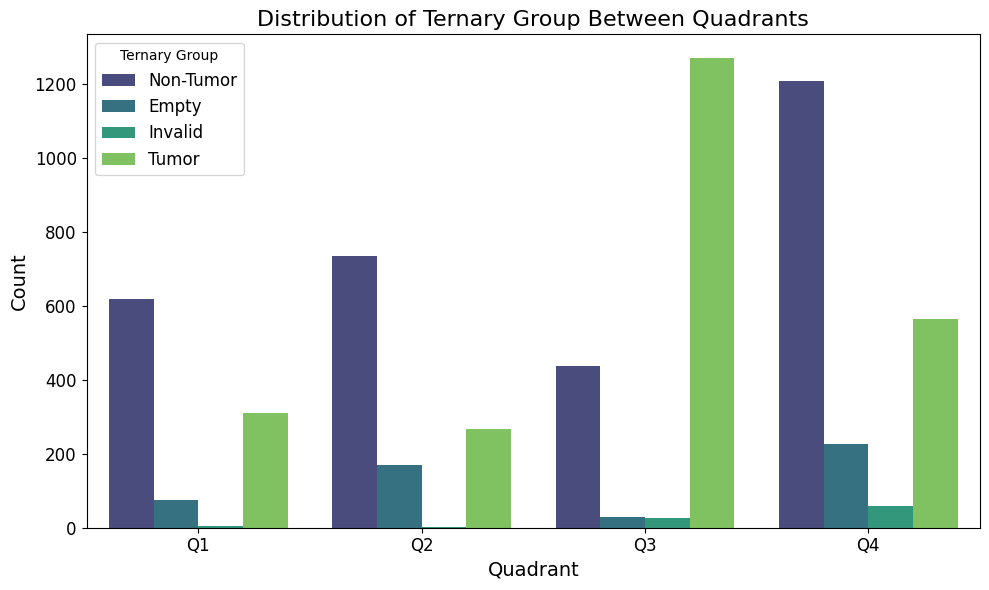

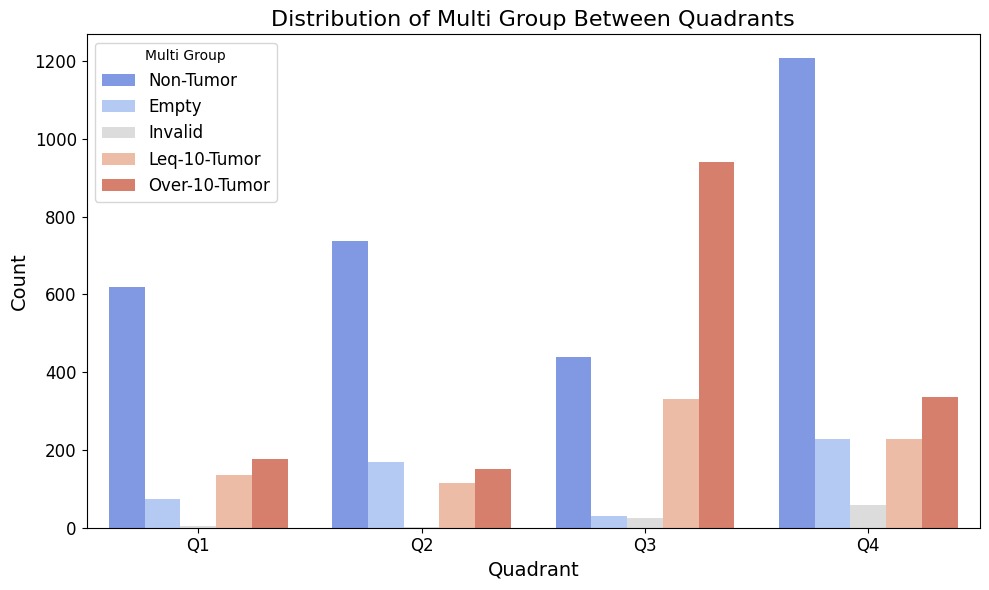

In [18]:
# Bar plot for ternary_group distribution between quadrants
plt.figure(figsize=(10, 6))
sns.countplot(data=annotated_grid_df, x='quadrant', hue='ternary_group', palette='viridis')
plt.title('Distribution of Ternary Group Between Quadrants', fontsize=16)
plt.xlabel('Quadrant', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Ternary Group', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Bar plot for multi_group distribution between quadrants
plt.figure(figsize=(10, 6))
sns.countplot(data=annotated_grid_df, x='quadrant', hue='multi_group', palette='coolwarm')
plt.title('Distribution of Multi Group Between Quadrants', fontsize=16)
plt.xlabel('Quadrant', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Multi Group', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### DROP GRID SQUARES that only have invalid cells
- if grid squares only have invalid cells, we drop these

In [19]:
print(annotated_grid_df[annotated_grid_df["multi_group"] == "Invalid"].head())
print(annotated_grid_df[annotated_grid_df["ternary_group"] == "Invalid"].head())

# drop grids from annotated_grid_df where group == "Invalid"
annotated_grid_df = annotated_grid_df[annotated_grid_df["ternary_group"] != "Invalid"]
annotated_grid_df = annotated_grid_df[annotated_grid_df["multi_group"] != "Invalid"]

     quadrant                         box grid_id  \
154        Q1  (13825, 9656, 14049, 9880)   61_43   
213        Q1  (13377, 7192, 13601, 7416)   59_32   
493        Q1  (10689, 8984, 10913, 9208)   47_40   
667        Q1    (9121, 7640, 9345, 7864)   40_34   
1267       Q2  (24290, 7640, 24514, 7864)  108_34   

                                               geometry  Invalid  Non-Tumor  \
154   POLYGON ((13825 9656, 13825 9880, 14049 9880, ...      1.0        0.0   
213   POLYGON ((13377 7192, 13377 7416, 13601 7416, ...      1.0        0.0   
493   POLYGON ((10689 8984, 10689 9208, 10913 9208, ...      1.0        0.0   
667   POLYGON ((9121 7640, 9121 7864, 9345 7864, 934...      1.0        0.0   
1267  POLYGON ((24290 7640, 24290 7864, 24514 7864, ...      1.0        0.0   

      Tumor ternary_group multi_group  
154     0.0       Invalid     Invalid  
213     0.0       Invalid     Invalid  
493     0.0       Invalid     Invalid  
667     0.0       Invalid     Invalid  
1267  

## Using labels to produce dataset

### Trying to run stratified down-sampling + upsampling 
Procedure
- go over each fold
- go over each grid square, try get TOTAL_SAMPLE_SIZE/2 (upsampling if required) from each of tumour + non tumour, and empty class size for empty classes
    get  TOTAL_SAMPLE_SIZE/2 from each group = stratification
    for multiclass, get TOTAL_SAMPLE_SIZE/3
- visualise these

Note, this involves 'sampling' from image_df, and then reproducing grouped/summary dfs based on this. If not enough images, just add what we have, and upsampling procedure considered later.

In [20]:
# go over each fold
# go over each cell type, and downsamplee as reqd from each one (ignoring hybrid + unlabelled)
# Initialize a list to store sampled data
stratified_down_data_ternary = []
stratified_up_data_ternary = []
upsampling_required_ternary = {} # upsampled images will actually be produced later, so store how many more images needed for which folds/classes

stratified_down_data_multiclass = []
stratified_up_data_multiclass = []
upsampling_required_multiclass = {} # upsampled images will actually be produced later, so store how many more images needed for which folds/classes

# Iterate over each fold
for fold in annotated_grid_df['quadrant'].unique():
    fold_data = annotated_grid_df[annotated_grid_df['quadrant'] == fold]
        
    # Sample data from each group in this fold
    for group in fold_data['ternary_group'].unique():
        # find the desired number of images from this fold
        if (group == "Empty"):
            desired_count = math.ceil(EMPTY_CLASS_SIZE/2) # DIVIDED BY 2, TAKE 1/2 FROM FOLDS, TAKE 1/2 FROM CORNERS OF IMAGES
        else:
            # -1, as empty class handled seperately
            desired_count = math.ceil(TOTAL_SAMPLE_SIZE/(len(fold_data['ternary_group'].unique()) - 1)) 

        group_data = fold_data[fold_data['ternary_group'] == group]
        
        if len(group_data) >= desired_count:
            stratified_down_data_ternary.append(group_data.sample(n=desired_count, random_state=RANDOM_SEED, replace=False))
        else:
            print(f"Warning: Not enough data for {group} (ternary) in {fold}. Found {len(group_data)} images, but needed {desired_count}.")
            stratified_down_data_ternary.append(group_data)
            stratified_up_data_ternary.append(group_data)
            upsampling_required_ternary[fold, group] = desired_count

    for group in fold_data['multi_group'].unique():
        # find the desired number of images from this fold
        if (group == "Empty"):
            desired_count = math.ceil(EMPTY_CLASS_SIZE/2) # DIVIDED BY 2, TAKE 1/2 FROM FOLDS, TAKE 1/2 FROM CORNERS OF IMAGES
        else:
            # -1, as empty class handled seperately
            desired_count = math.ceil(TOTAL_SAMPLE_SIZE/(len(fold_data['multi_group'].unique()) - 1)) 

        group_data = fold_data[fold_data['multi_group'] == group]
        
        if len(group_data) >= desired_count:
            stratified_down_data_multiclass.append(group_data.sample(n=desired_count, random_state=RANDOM_SEED, replace=False))
        else:
            print(f"Warning: Not enough data for {group} (multiclass) in {fold}. Found {len(group_data)} images, but needed {desired_count}.")
            stratified_down_data_multiclass.append(group_data)
            stratified_up_data_multiclass.append(group_data)
            upsampling_required_multiclass[fold, group] = desired_count

        

# Combine all sampled data into a single DataFrame
if (len(stratified_down_data_ternary) > 0):
    stratified_down_ternary_df = pd.concat(stratified_down_data_ternary) 
else:
    print("Warning: nothing came out after downsampling ternary")
    stratified_down_ternary_df = pd.DataFrame(columns=annotated_grid_df.columns)

if (len(stratified_up_data_ternary) > 0):
    stratified_up_ternary_df = pd.concat(stratified_up_data_ternary)  
else:
    print("Warning: nothing to upsample ternary")
    stratified_up_ternary_df = pd.DataFrame(columns=annotated_grid_df.columns)

if (len(stratified_down_data_multiclass) > 0):
    stratified_down_multiclass_df = pd.concat(stratified_down_data_multiclass)  
else:
    print("Warning: nothing came out after downsampling multiclass")
    stratified_down_multiclass_df = pd.DataFrame(columns=annotated_grid_df.columns)

if (len(stratified_up_data_multiclass) > 0):    
    stratified_up_multiclass_df = pd.concat(stratified_up_data_multiclass)  
else:
    print("Warning: nothing to upsample multiclass")
    stratified_up_multiclass_df = pd.DataFrame(columns=annotated_grid_df.columns)

print(stratified_down_ternary_df.head())
print(upsampling_required_ternary)
print(stratified_down_multiclass_df.head())
print(upsampling_required_multiclass)

     quadrant                           box grid_id  \
206        Q1    (13377, 8760, 13601, 8984)   59_39   
900        Q1      (6881, 9208, 7105, 9432)   30_41   
1006       Q1      (5985, 6968, 6209, 7192)   26_31   
176        Q1  (13601, 10104, 13825, 10328)   60_45   
167        Q1    (13825, 6744, 14049, 6968)   61_30   

                                               geometry  Invalid  Non-Tumor  \
206   POLYGON ((13377 8760, 13377 8984, 13601 8984, ...      0.0        5.0   
900   POLYGON ((6881 9208, 6881 9432, 7105 9432, 710...      0.0       30.0   
1006  POLYGON ((5985 6968, 5985 7192, 6209 7192, 620...      0.0       19.0   
176   POLYGON ((13601 10104, 13601 10328, 13825 1032...      0.0        2.0   
167   POLYGON ((13825 6744, 13825 6968, 14049 6968, ...      0.0        2.0   

      Tumor ternary_group multi_group  
206     0.0     Non-Tumor   Non-Tumor  
900     0.0     Non-Tumor   Non-Tumor  
1006    0.0     Non-Tumor   Non-Tumor  
176     0.0     Non-Tumor   Non-Tu

### Visualising

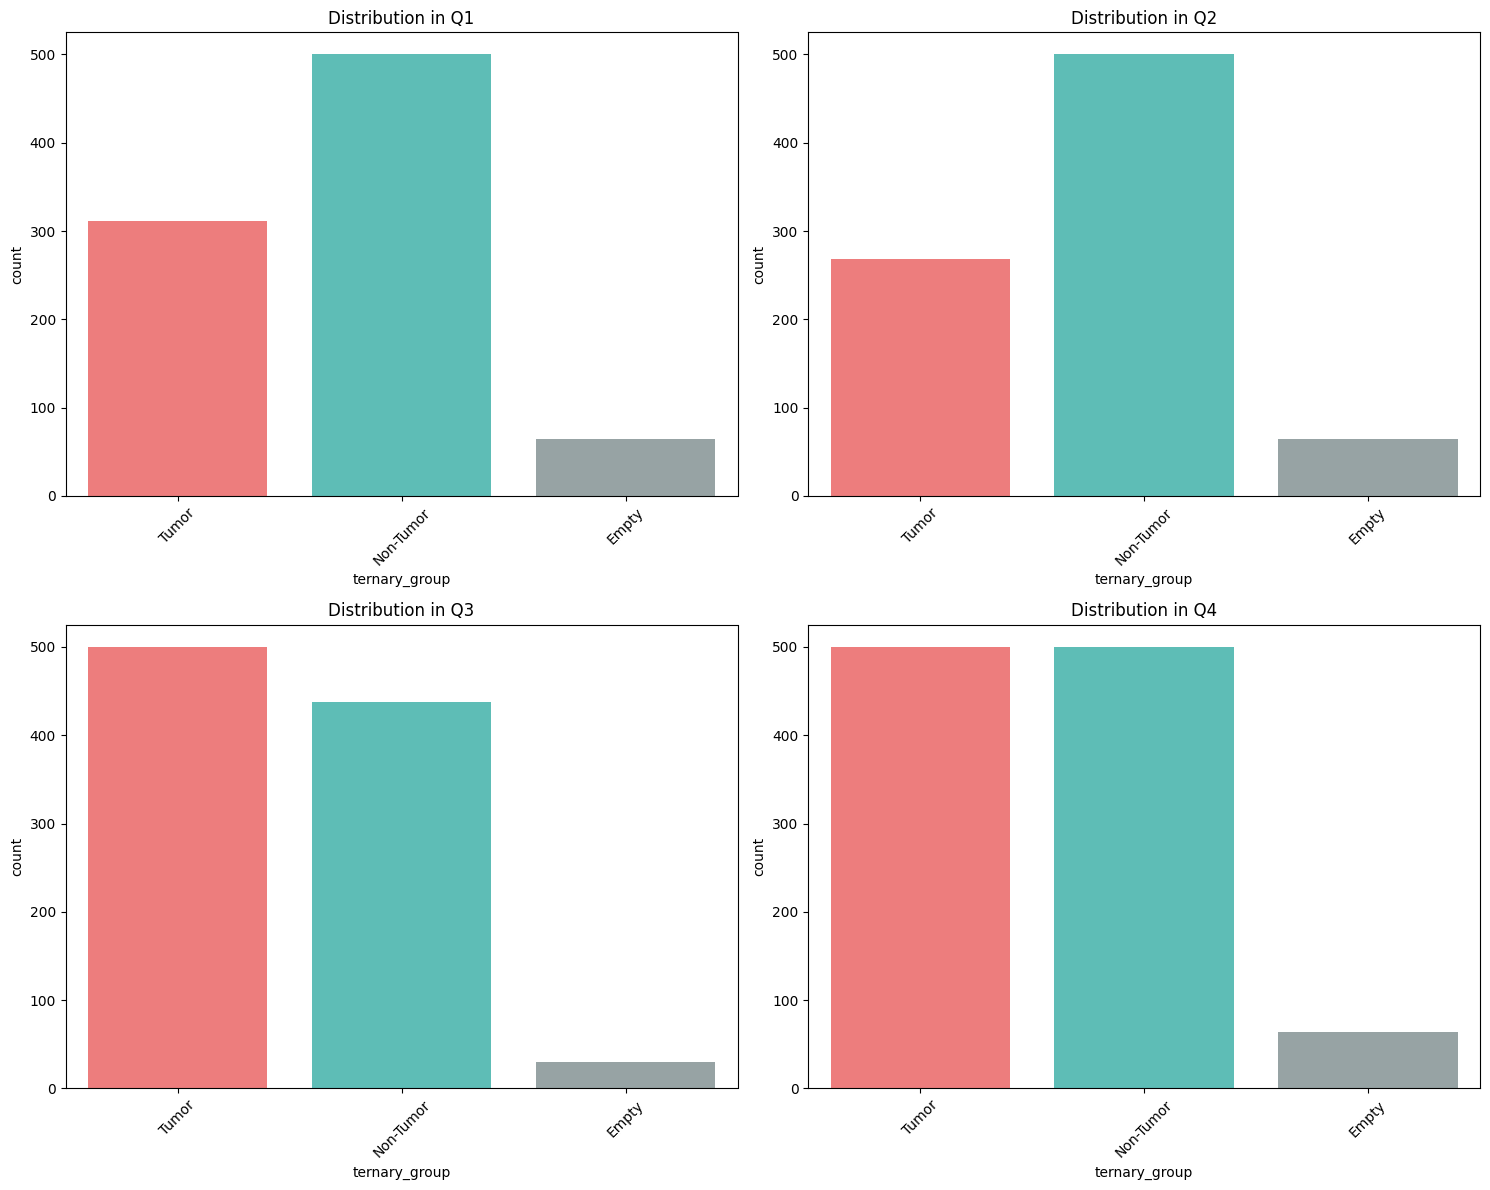

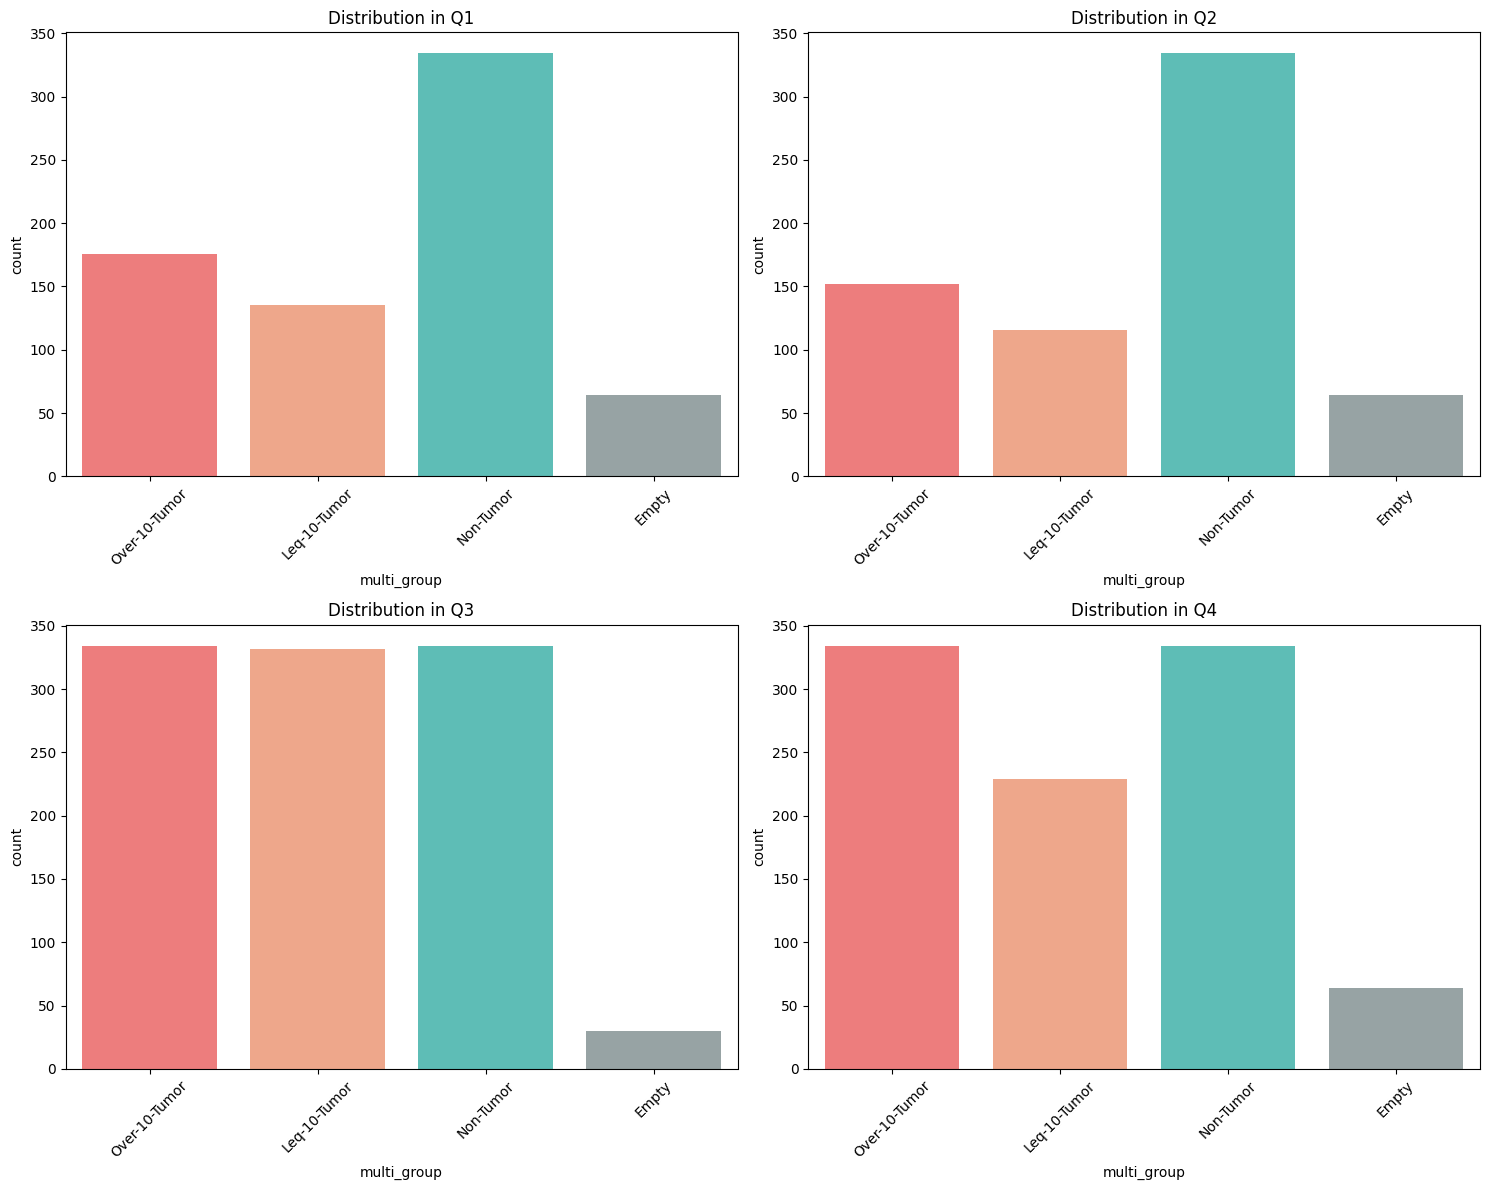

In [16]:
# Create figure for ternary groups
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Define color palette for ternary groups
ternary_colors = {
    'Tumor': '#FF6B6B',      # Red
    'Non-Tumor': '#4ECDC4',  # Teal 
    'Empty': '#95A5A6'       # Gray
}

# Define order for ternary groups
ternary_order = ['Tumor', 'Non-Tumor', 'Empty']

# Plot distribution for each quadrant - ternary
for i, quadrant in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    quadrant_data = stratified_down_ternary_df[stratified_down_ternary_df['quadrant'] == quadrant]
    sns.countplot(data=quadrant_data, x='ternary_group', ax=axes[i], 
                 order=ternary_order,
                 palette=ternary_colors,
                 hue='ternary_group')
    axes[i].set_title(f'Distribution in {quadrant}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Create figure for multiclass groups
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Define color palette for multiclass groups # BREAKS WHEN image size changed
multiclass_colors = {
    f'Over-{cutoff}-Tumor': '#FF6B6B',    # Red
    f'Leq-{cutoff}-Tumor': '#FFA07A',   # Light red
    'Non-Tumor': '#4ECDC4',    # Teal
    'Empty': '#95A5A6'         # Gray
}

# Define order for multiclass groups
multiclass_order = [f'Over-{cutoff}-Tumor', f'Leq-{cutoff}-Tumor', 'Non-Tumor', 'Empty']

# Plot distribution for each quadrant - multiclass
for i, quadrant in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    quadrant_data = stratified_down_multiclass_df[stratified_down_multiclass_df['quadrant'] == quadrant]
    sns.countplot(data=quadrant_data, x='multi_group', ax=axes[i],
                 order=multiclass_order,
                 palette=multiclass_colors,
                 hue='multi_group')
    axes[i].set_title(f'Distribution in {quadrant}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Generate datasets
- create and populate '{OUTPUT_BASE}/[Fold]/[Group]' with images

### Most grid sqaures are just cropped from big image and saved

In [24]:
big_image = PIL.Image.open(BIG_IMAGE_PATH)

In [ ]:
if (GENERATE_TERNARY_DATA == True):
    # delete the folder OUTPUT_BASE if it exists
    if os.path.exists(OUTPUT_BASE_TERNARY):
        shutil.rmtree(OUTPUT_BASE_TERNARY)
        print(f"Deleted existing ternary dataset at '{OUTPUT_BASE_TERNARY}'")
    
    # Copy images to corresponding quadrant subfolders
    for _, row in stratified_down_ternary_df.iterrows():
        
        group = row["ternary_group"]
        quadrant = row["quadrant"]
        grid_id = row["grid_id"]

        dst_folder = os.path.join(OUTPUT_BASE_TERNARY, quadrant, group)       
        os.makedirs(dst_folder, exist_ok=True)
        dst_path = os.path.join(dst_folder, f"grid_{grid_id}_{DESIRED_IMAGE_SIZE}.png")
        big_image.crop(row["box"]).save(dst_path)

    print(f"Produced new downsampled ternary dataset at '{OUTPUT_BASE_TERNARY}'")

Produced new downsampled ternary dataset at 'projectdata\images\uncentred_ternary_224_stratified4fold_1000per_seed3888'


In [ ]:
if (GENERATE_MULTI_DATA == True):
    # delete the folder OUTPUT_BASE if it exists
    if os.path.exists(OUTPUT_BASE_MULTI):
        shutil.rmtree(OUTPUT_BASE_MULTI)
        print(f"Deleted existing multiclass dataset at '{OUTPUT_BASE_MULTI}'")
    
    # Copy images to corresponding quadrant subfolders
    for _, row in stratified_down_multiclass_df.iterrows():
        
        group = row["multi_group"]
        quadrant = row["quadrant"]
        grid_id = row["grid_id"]

        dst_folder = os.path.join(OUTPUT_BASE_MULTI, quadrant, group)       
        os.makedirs(dst_folder, exist_ok=True)
        dst_path = os.path.join(dst_folder, f"grid_{grid_id}_{DESIRED_IMAGE_SIZE}.png")
        big_image.crop(row["box"]).save(dst_path)

    print(f"Produced new downsampled multiclass dataset at '{OUTPUT_BASE_MULTI}'")

Produced new downsampled multiclass dataset at 'projectdata\images\uncentred_multiclass_224_stratified4fold_1000per_seed3888'


### Generate all grids for each quadrant

In [22]:
OUTPUT_BASE_TERNARY_TEST = os.path.join("projectdata", "images", f"test_uncentred_ternary_{DESIRED_IMAGE_SIZE}_stratified4fold_{TOTAL_SAMPLE_SIZE}per_seed{RANDOM_SEED}") # path to output images

if os.path.exists(OUTPUT_BASE_TERNARY_TEST):
    shutil.rmtree(OUTPUT_BASE_TERNARY_TEST)
    print(f"Deleted existing ternary dataset at '{OUTPUT_BASE_TERNARY_TEST}'")

# Copy images to corresponding quadrant subfolders
for _, row in annotated_grid_df.iterrows():
    
    group = row["ternary_group"]
    quadrant = row["quadrant"]
    grid_id = row["grid_id"]

    dst_folder = os.path.join(OUTPUT_BASE_TERNARY_TEST, quadrant, group)       
    os.makedirs(dst_folder, exist_ok=True)
    dst_path = os.path.join(dst_folder, f"grid_{grid_id}_{DESIRED_IMAGE_SIZE}.png")
    big_image.crop(row["box"]).save(dst_path)

export_columns = ["quadrant", "box", "grid_id", "ternary_group"]
export_df = annotated_grid_df[export_columns]
export_df.to_csv(os.path.join(OUTPUT_BASE_TERNARY_TEST, "grid_metadata.csv"), index=False)

print(f"Produced test ternary dataset at '{OUTPUT_BASE_TERNARY_TEST}'")


Produced test ternary dataset at 'projectdata\images\test_uncentred_ternary_224_stratified4fold_1000per_seed3888'


In [26]:
# free memory
big_image.close()
del big_image

### Now we just need to handle upsampling

In [ ]:
# go over samples in need of upsampling
for (quadrant, group), desired_count in upsampling_required_ternary.items():
    # subset data
    subset_stratified_up_df = stratified_up_ternary_df[
        (stratified_up_ternary_df["quadrant"] == quadrant) & (stratified_up_ternary_df["ternary_group"] == group)
    ]
    print(f"Fold: {quadrant}, Ternary Group: {group}, Desired Count: {desired_count}, Actual Count: {len(subset_stratified_up_df)}")

    # get images we just produced 
    raw_images = {}
    dst_folder = os.path.join(OUTPUT_BASE_TERNARY, quadrant, group)
    for file_name in os.listdir(dst_folder):
        file_path = os.path.join(dst_folder, file_name)
        try:
            image = PIL.Image.open(file_path)
            raw_images[file_name] = image
        except FileNotFoundError:
            print(f"Warning: {file_path} not found. Skipping this image.")

    # apply 5 transformations to each image, save these in memory
    tf_images = {}
    transformations = [
        lambda img: img.rotate(90, expand=True),
        lambda img: img.rotate(180, expand=True),
        lambda img: img.rotate(270, expand=True),
        lambda img: img.transpose(PIL.Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
    ]
    for index, img in raw_images.items():
        for i, transformation in enumerate(transformations):
            tf_images[f"{index}_upsampled{i}"] = transformation(img)

    # Calculate the number of additional images needed
    additional_count = desired_count - len(subset_stratified_up_df)
    
    # Take a random sample of the required size from the transformed images
    if (additional_count <= len(tf_images)):
        random.seed(RANDOM_SEED)
        upsampled_images_l = random.sample(sorted(tf_images), k=additional_count)
        upsampled_images = {key: tf_images[key] for key in upsampled_images_l}
    else:
        print(f"Warning: Not enough transformed images for ternary {group} in {quadrant}. Using all available transformed images.")
        upsampled_images = tf_images

    # output results, and data to regenerate visualisations from before
    print(f"Upsampled to make {len(upsampled_images)} images, New count: {len(subset_stratified_up_df) + len(upsampled_images)} out of desired {desired_count}\n")
    # Update group_counts2 to increment the count for the specific fold and cell group
    #group_counts2.loc[(group_counts2['Fold'] == quadrant) & (group_counts2['Cell Group'] == cell_group_map[cell_type]), 'Count'] += len(upsampled_images)
    #fold_totals.loc[fold_totals['Fold'] == quadrant, 'Count'] += len(upsampled_images)
    
    # save them to same dest folder as before
    if (GENERATE_TERNARY_DATA == True):
        for label, img in upsampled_images.items():
            # this may throw errors, handle as they come
            dst_folder = os.path.join(OUTPUT_BASE_TERNARY, quadrant, group)
            dst_path = os.path.join(dst_folder, f"{label}.png")
            img.save(dst_path)
        print(f"Added upsampled images to ternary dataset at '{OUTPUT_BASE_TERNARY}'")

Fold: Q1, Ternary Group: Tumor, Desired Count: 500, Actual Count: 311
Upsampled to make 189 images, New count: 500 out of desired 500

Added upsampled images to ternary dataset at 'projectdata\images\uncentred_ternary_224_stratified4fold_1000per_seed3888'
Fold: Q2, Ternary Group: Tumor, Desired Count: 500, Actual Count: 268
Upsampled to make 232 images, New count: 500 out of desired 500

Added upsampled images to ternary dataset at 'projectdata\images\uncentred_ternary_224_stratified4fold_1000per_seed3888'
Fold: Q3, Ternary Group: Empty, Desired Count: 64, Actual Count: 30
Upsampled to make 34 images, New count: 64 out of desired 64

Added upsampled images to ternary dataset at 'projectdata\images\uncentred_ternary_224_stratified4fold_1000per_seed3888'
Fold: Q3, Ternary Group: Non-Tumor, Desired Count: 500, Actual Count: 438
Upsampled to make 62 images, New count: 500 out of desired 500

Added upsampled images to ternary dataset at 'projectdata\images\uncentred_ternary_224_stratified4f

In [ ]:
# go over samples in need of upsampling
for (quadrant, group), desired_count in upsampling_required_multiclass.items():
    # subset data
    subset_stratified_up_df = stratified_up_multiclass_df[
        (stratified_up_multiclass_df["quadrant"] == quadrant) & (stratified_up_multiclass_df["multi_group"] == group)
    ]
    print(f"Fold: {quadrant}, Multiclass Group: {group}, Desired Count: {desired_count}, Actual Count: {len(subset_stratified_up_df)}")

    # get images we just produced 
    raw_images = {}
    dst_folder = os.path.join(OUTPUT_BASE_MULTI, quadrant, group)
    for file_name in os.listdir(dst_folder):
        file_path = os.path.join(dst_folder, file_name)
        try:
            image = PIL.Image.open(file_path)
            raw_images[file_name] = image
        except FileNotFoundError:
            print(f"Warning: {file_path} not found. Skipping this image.")

    # apply 5 transformations to each image, save these in memory
    tf_images = {}
    transformations = [
        lambda img: img.rotate(90, expand=True),
        lambda img: img.rotate(180, expand=True),
        lambda img: img.rotate(270, expand=True),
        lambda img: img.transpose(PIL.Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
    ]
    for index, img in raw_images.items():
        for i, transformation in enumerate(transformations):
            tf_images[f"{index}_upsampled{i}"] = transformation(img)

    # Calculate the number of additional images needed
    additional_count = desired_count - len(subset_stratified_up_df)
    
    # Take a random sample of the required size from the transformed images
    if (additional_count <= len(tf_images)):
        random.seed(RANDOM_SEED)
        upsampled_images_l = random.sample(sorted(tf_images), k=additional_count)
        upsampled_images = {key: tf_images[key] for key in upsampled_images_l}
    else:
        print(f"Warning: Not enough transformed images for multiclass {group} in {quadrant}. Using all available transformed images.")
        upsampled_images = tf_images

    # output results, and data to regenerate visualisations from before
    print(f"Upsampled to make {len(upsampled_images)} images, New count: {len(subset_stratified_up_df) + len(upsampled_images)} out of desired {desired_count}\n")
    # Update group_counts2 to increment the count for the specific fold and cell group
    #group_counts2.loc[(group_counts2['Fold'] == quadrant) & (group_counts2['Cell Group'] == cell_group_map[cell_type]), 'Count'] += len(upsampled_images)
    #fold_totals.loc[fold_totals['Fold'] == quadrant, 'Count'] += len(upsampled_images)
    
    # save them to same dest folder as before
    if (GENERATE_MULTI_DATA == True):
        for label, img in upsampled_images.items():
            # this may throw errors, handle as they come
            dst_folder = os.path.join(OUTPUT_BASE_MULTI, quadrant, group)
            dst_path = os.path.join(dst_folder, f"{label}.png")
            img.save(dst_path)
        print(f"Added upsampled images to multiclass dataset at '{OUTPUT_BASE_MULTI}'")

Fold: Q1, Multiclass Group: Leq-10-Tumor, Desired Count: 334, Actual Count: 135
Upsampled to make 199 images, New count: 334 out of desired 334

Added upsampled images to multiclass dataset at 'projectdata\images\uncentred_multiclass_224_stratified4fold_1000per_seed3888'
Fold: Q1, Multiclass Group: Over-10-Tumor, Desired Count: 334, Actual Count: 176
Upsampled to make 158 images, New count: 334 out of desired 334

Added upsampled images to multiclass dataset at 'projectdata\images\uncentred_multiclass_224_stratified4fold_1000per_seed3888'
Fold: Q2, Multiclass Group: Over-10-Tumor, Desired Count: 334, Actual Count: 152
Upsampled to make 182 images, New count: 334 out of desired 334

Added upsampled images to multiclass dataset at 'projectdata\images\uncentred_multiclass_224_stratified4fold_1000per_seed3888'
Fold: Q2, Multiclass Group: Leq-10-Tumor, Desired Count: 334, Actual Count: 116
Upsampled to make 218 images, New count: 334 out of desired 334

Added upsampled images to multiclass 

### Add in empty images taken from corners
- Some quadrants are barely gonna have empty grids, and we want some clear examples of what 'empty' means for our classifiers

#### Make sure the corners are as expected

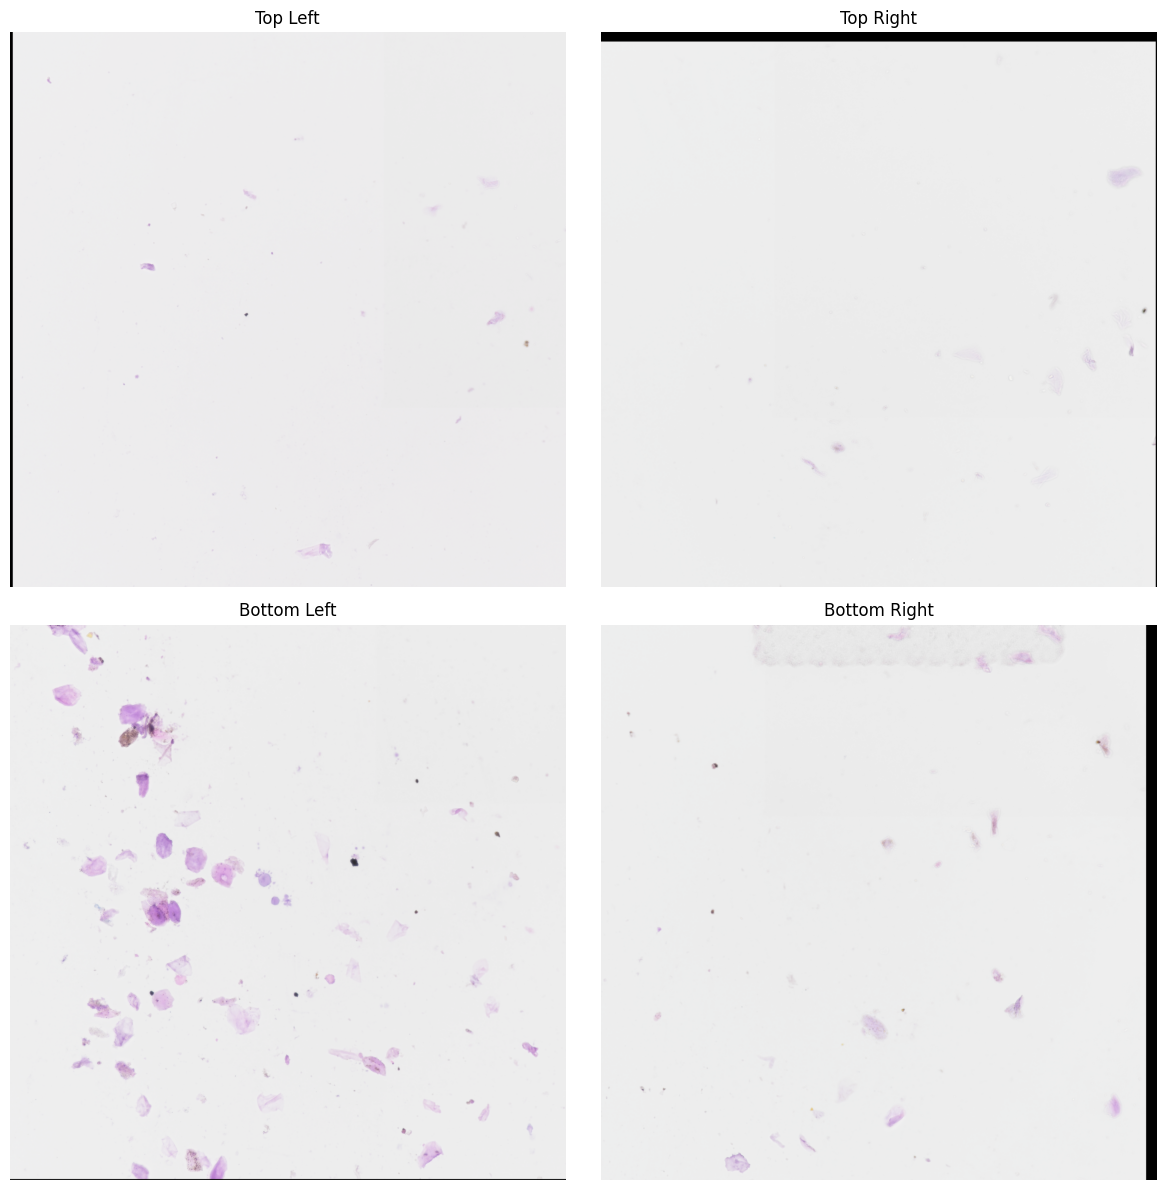

In [29]:
# Increase the limit for large images
PIL.Image.MAX_IMAGE_PIXELS = None  # Set to None to remove the limit

# open image
big_image = PIL.Image.open(BIG_IMAGE_PATH)
width, height = big_image.size

# calculate the size of the cropped images
crop_size = DESIRED_IMAGE_SIZE * int(math.sqrt(EMPTY_CLASS_SIZE/2)) # checked to be perfect square already

# Define the coordinates for the four corners
top_left = (0, 0, crop_size, crop_size)
top_right = (width - crop_size, 0, width, crop_size)
bottom_left = (0, height - crop_size, crop_size, height)
bottom_right = (width - crop_size, height - crop_size, width, height)

# Crop the big image
empty_regions = {}
empty_regions["Q1"] = big_image.crop(top_left).copy()
empty_regions["Q2"] = big_image.crop(top_right).copy()
empty_regions["Q3"] = big_image.crop(bottom_left).copy()
empty_regions["Q4"] = big_image.crop(bottom_right).copy()

big_image.close()
del big_image # free up memory

# Visualize the cropped images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].imshow(empty_regions["Q1"])
axes[0, 0].set_title("Top Left")
axes[0, 1].imshow(empty_regions["Q2"])
axes[0, 1].set_title("Top Right")
axes[1, 0].imshow(empty_regions["Q3"])
axes[1, 0].set_title("Bottom Left")
axes[1, 1].imshow(empty_regions["Q4"])
axes[1, 1].set_title("Bottom Right")

for ax in axes.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Generate images in dataset

In [ ]:
corner_names = {"Q1": "topleft", "Q2": "topright", "Q3": "bottomleft", "Q4": "bottomright"}

# Split corners into MAX_IMAGE_SIZE x MAX_IMAGE_SIZE chunks, and save the images
for quadrant, corner_image in empty_regions.items():
    for i in range(0, crop_size, DESIRED_IMAGE_SIZE):
        for j in range(0, crop_size, DESIRED_IMAGE_SIZE):
            # Define the box for cropping
            box = (i, j, i + DESIRED_IMAGE_SIZE, j + DESIRED_IMAGE_SIZE)
            cropped_image = corner_image.crop(box)

            if (GENERATE_MULTI_DATA == True):
                # Save the cropped image
                dst_folder = os.path.join(OUTPUT_BASE_MULTI, quadrant, "Empty")
                os.makedirs(dst_folder, exist_ok=True)
                dst_path = os.path.join(dst_folder, f"{corner_names[quadrant]}_{int(i/DESIRED_IMAGE_SIZE)}_{int(j/DESIRED_IMAGE_SIZE)}.png")
                cropped_image.save(dst_path)

            if (GENERATE_TERNARY_DATA == True):
                # Save the cropped image
                dst_folder = os.path.join(OUTPUT_BASE_TERNARY, quadrant, "Empty")
                os.makedirs(dst_folder, exist_ok=True)
                dst_path = os.path.join(dst_folder, f"{corner_names[quadrant]}_{int(i/DESIRED_IMAGE_SIZE)}_{int(j/DESIRED_IMAGE_SIZE)}.png")
                cropped_image.save(dst_path)
                
if (GENERATE_MULTI_DATA == True):                 
    print(f"Added empty image from CORNERS (size: {EMPTY_CLASS_SIZE/2} x 4 folds) to dataset at '{OUTPUT_BASE_MULTI}'")

if (GENERATE_TERNARY_DATA == True):                 
    print(f"Added empty image from CORNERS (size: {EMPTY_CLASS_SIZE/2} x 4 folds) to dataset at '{OUTPUT_BASE_TERNARY}'")

Added empty image from CORNERS (size: 64.0 x 4 folds) to dataset at 'projectdata\images\uncentred_multiclass_224_stratified4fold_1000per_seed3888'
Added empty image from CORNERS (size: 64.0 x 4 folds) to dataset at 'projectdata\images\uncentred_ternary_224_stratified4fold_1000per_seed3888'


# Troubleshooting (wont make sense unless being run on 224x224)

Example of a grid image that clearly has no cells, but was labelled otherwsie. Turns out cbr data isnt accurate.

     quadrant                           box grid_id  \
4085       Q4  (25858, 19089, 26082, 19313)  115_85   

                                               geometry  Invalid  Non-Tumor  \
4085  POLYGON ((25858 19089, 25858 19313, 26082 1931...      1.0       24.0   

      Tumor ternary_group    multi_group  
4085   14.0         Tumor  Over-10-Tumor  


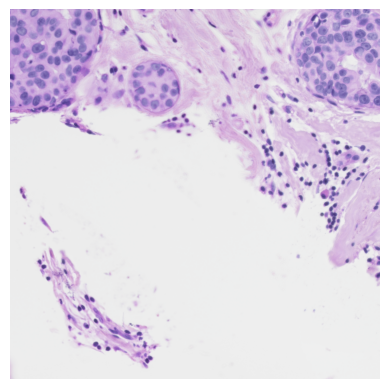

      index_left0   index        Cluster      group quadrant  \
4085       151847  151848  Myoepi_ACTA2+  Non-Tumor       Q4   
4085       151848  151849  Myoepi_KRT15+  Non-Tumor       Q4   
4085       151849  151850         DCIS 1      Tumor       Q4   
4085       151852  151853         DCIS 1      Tumor       Q4   
4085       151853  151854         DCIS 1      Tumor       Q4   

                               box grid_id  \
4085  (25858, 19089, 26082, 19313)  115_85   
4085  (25858, 19089, 26082, 19313)  115_85   
4085  (25858, 19089, 26082, 19313)  115_85   
4085  (25858, 19089, 26082, 19313)  115_85   
4085  (25858, 19089, 26082, 19313)  115_85   

                                               geometry  
4085  POLYGON ((25858 19089, 25858 19313, 26082 1931...  
4085  POLYGON ((25858 19089, 25858 19313, 26082 1931...  
4085  POLYGON ((25858 19089, 25858 19313, 26082 1931...  
4085  POLYGON ((25858 19089, 25858 19313, 26082 1931...  
4085  POLYGON ((25858 19089, 25858 19313, 26082 

In [31]:
# this one should be empty
grid_to_check = annotated_grid_df[annotated_grid_df["grid_id"] == "115_85"]
print(grid_to_check)

big_image = PIL.Image.open(BIG_IMAGE_PATH)

# Get the box coordinates from the first (and should be only) row where grid_id matches
box_coords = list(grid_to_check["box"].iloc[0])
box_coords[0] = box_coords[0] - 500
box_coords[1] = box_coords[1] - 500
box_coords[2] = box_coords[2] + 500
box_coords[3] = box_coords[3] + 500

plt.imshow(big_image.crop(box_coords))
plt.axis('off')
plt.show()

# Close the image to free memory
big_image.close()
del big_image

g_grid_to_check = grid_gdf[grid_gdf["grid_id"] == "115_85"]

# Use spatial join to find cells within this grid
cells_within = gpd.sjoin(cell_gdf, g_grid_to_check, how="right", predicate="within")
print(cells_within.head(5))


     quadrant                           box grid_id  \
4094       Q4  (25858, 17073, 26082, 17297)  115_76   

                                               geometry  Invalid  Non-Tumor  \
4094  POLYGON ((25858 17073, 25858 17297, 26082 1729...      0.0        0.0   

      Tumor ternary_group multi_group  
4094    0.0         Empty       Empty  


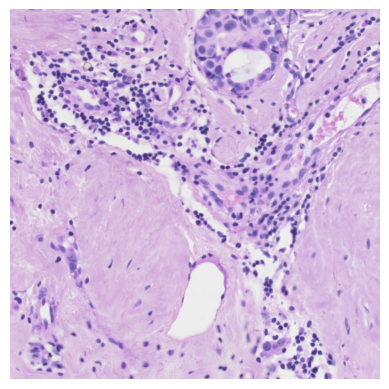

      index_left0  index Cluster group quadrant                           box  \
4094          NaN    NaN     NaN   NaN       Q4  (25858, 17073, 26082, 17297)   

     grid_id                                           geometry  
4094  115_76  POLYGON ((25858 17073, 25858 17297, 26082 1729...  


In [89]:
# this one seems to have cells
grid_to_check = annotated_grid_df[annotated_grid_df["grid_id"] == "115_76"]
print(grid_to_check)

big_image = PIL.Image.open(BIG_IMAGE_PATH)

# Get the box coordinates from the first (and should be only) row where grid_id matches
box_coords = list(grid_to_check["box"].iloc[0])
box_coords[0] = box_coords[0] - 500
box_coords[1] = box_coords[1] - 500
box_coords[2] = box_coords[2] + 500
box_coords[3] = box_coords[3] + 500

plt.imshow(big_image.crop(box_coords))
plt.axis('off')
plt.show()

# Close the image to free memory
big_image.close()
del big_image

g_grid_to_check = grid_gdf[grid_gdf["grid_id"] == "115_76"]

# Use spatial join to find cells within this grid
cells_within = gpd.sjoin(cell_gdf, g_grid_to_check, how="right", predicate="within")
print(cells_within.head(5))
